# Project 2
## Image clustering and compression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import math
np.random.seed(0)

## Load Data

In [2]:
from PIL import Image
from numpy import asarray

#from google.colab import files
#uploaded = files.upload()

def loadData():
  # load the image
  image = Image.open('im.jpg')
  # convert image to numpy array
  data = asarray(image)
  # summarize shape
  print("Image data shape : ",data.shape)
    
  X= data.reshape(data.shape[0]*data.shape[1],data.shape[2])
  print("2D image data : ",X.shape)

  #Normalize image
  X = X.astype(float)/255
  #print("Normalized X.shape : ",X.shape)

  return X

## Parameter Initialization

In [4]:
def parameterInitialization(K,X): 
    M = np.array([np.mean(X, axis=0),]*K) + np.random.randn(K,X.shape[1])
    S = np.zeros((K)) 
    p = np.zeros((K))
    for k in range(K):
        S[k]= np.random.rand(1)
        p[k]= 1/K;
    return M,S,p

## Compute Gaussian distribution

In [6]:
def computeGaussianDistr(x,m,s):
    return ((1/(np.sqrt(2*math.pi*s)))*np.exp((-1/(2*s))*np.square(x-m))) 

## Compute gamma

In [7]:
def computeGamma(X,M,S,p):
    N = X.shape[0]
    K = M.shape[0]

    gamma = np.zeros((N,K))
    L = np.zeros((N,K))
    
    
    for n in range(N):
      J=0
      for k in range(K):
            gamma[n,k] = p[k]*sum(computeGaussianDistr(X[n], M[k],S[k]))
            L[n,k] = p[k]*sum(computeGaussianDistr(X[n], M[k],S[k]))
            J+= sum(p[k]*computeGaussianDistr(X[n], M[k],S[k]))
      
      gamma[n] = gamma[n]/J
    
    return gamma,L

## Compute M (means)

In [9]:

def computeM(gamma,X,M):
    K = M.shape[0]
    N = X.shape[0]

    for k in range(K):
        sumM = np.zeros((3))
        total = np.zeros((3))
        for i in range(N):
            sumM += X[i]*gamma[i,k]
            total += gamma[i,k]
                
        M[k]= sumM/total
    return M           
    
     

## Compute S

In [11]:

def computeS(gamma,X,M,S):
   
    N = X.shape[0]
    K = M.shape[0]
    D = X.shape[1]
    for k in range(K):
        sumS = 0
        total = 0
        for i in range(N):
            sumS += gamma[i,k] * sum(np.square(X[i]-M[k]))
            total += gamma[i,k]
        
        
        S[k]= sumS/(D*total)
    return S  

## Compute p

In [13]:

def computeP(gamma,X,M,p):
    K = M.shape[0]
    N = M.shape[0]
    D = X.shape[1]

    for k in range(K):
        sumN = 0
        for n in range(N):
            sumN += gamma[n,k]
                
        p[k]= sumN
    return p/int(N*D)

## Likelihood

In [15]:

def computeLikelihood(L,X):
    N = X.shape[0]

    totalCost=0
    J=0
    for n in range(N):
      J = sum(L[n])
      totalCost += np.log(J)
          
            
    return totalCost
            

In [17]:
#plot costs

def plot_costs(costs):
    x = range(1, len(costs)+1)
    y = costs
    plt.plot(x, y)
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title("Cost Function =")
    plt.xticks(x)
    plt.show()

## Assign to clusters

In [18]:
def assignToClusters(X,M):
    
  N = X.shape[0]
  K = M.shape[0]
  D = X.shape[1]
  
  Xclustered = np.zeros((N,D))
  for n in range(N):
            dist = np.zeros((K))
            for k in range(K):
                dist[k] = np.sum(np.square(X[n]-M[k]))
            Xclustered[n] = M[np.argmin(dist)]

  Xnew = Xclustered.reshape(690,550,3)
    


  return Xnew,Xclustered

## Compute Error

In [19]:
def computeError(X,Xclustered):
    N = X.shape[0]
    D = X.shape[1]
    error = 0
    for n in range(N):
        error += sum(np.square(X[n]-Xclustered[n]))
    
    return error/int(N*D)

## Expectation-Maximization Algorithm

In [20]:
def expectation_maximization():
    
    X = loadData()

    N = X.shape[0]
    D = X.shape[1]
    
    #number of clusters
    clusterNum = 4

    M,S,p = parameterInitialization(clusterNum,X)

    K = M.shape[0]
    
    tol = 1e-6#tolerance of convergence
    Jold = np.inf
    maxIters = 5#number of iterations
    
    costs = []
    
    for it in range(maxIters):  
        J=0

        gamma,L = computeGamma(X,M,S,p)
        #print("telos G----")

        M = computeM(gamma,X,M)
        #print("telos M----")
        
        S = computeS(gamma,X,M,S)
        #print("telos S----")
        
        p = computeP(gamma,X,M,p)
        #print("telos p----")
        
        J = computeLikelihood(L,X)
        #print("telos J----")
        costs.append(J)
        
        Xnew,Xclustered = assignToClusters(X,M)
        
        
        err = computeError(X,Xclustered)
        
        print("Iteration #{}, Cost function value: {}".format(it, J))
        print("Error : ",err)
        
        #plot image
        plt.imshow(Xnew)  
        plt.show()
        
        #save image, number of clusters, error, cost function value, iteration
        if it == 4 or (np.abs(J - Jold) < tol):
            L = "Number of clusters : "+str(clusterNum)+" Error : "+str(err)+" Cost function value : "+str(J)+" Iteration : "+str(it)+'\n'
            file1 = open("results.txt","a") 
            file1.writelines(L) 
            file1.close() 
            matplotlib.image.imsave('cluster'+str(clusterNum)+'.jpeg', Xnew)
        
        if np.abs(J - Jold) < tol:
            break
        Jold = J
        
        # Plot the cost function
    plot_costs(costs)
  

Image data shape :  (690, 550, 3)
2D image data :  (379500, 3)
Iteration #0, Cost function value: 81018.10705100064
Error :  0.03655464847347009


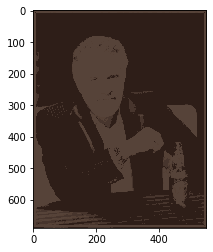

Iteration #1, Cost function value: 50987.17764246336
Error :  0.024276572856717613


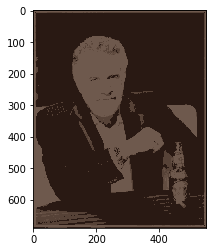

Iteration #2, Cost function value: 119728.6147115836
Error :  0.013158113623001339


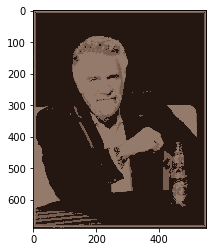

Iteration #3, Cost function value: 171825.3426989897
Error :  0.00917501022855093


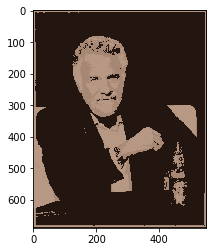

Iteration #4, Cost function value: 139866.71081746725
Error :  0.009475530758459654


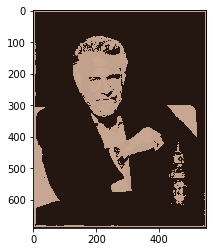

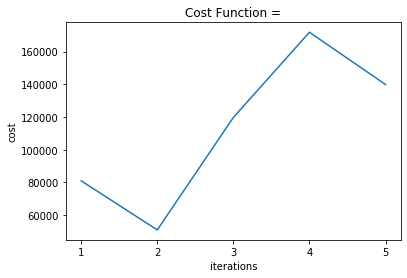

In [21]:
expectation_maximization()

# Results

### Number of clusters : 1 Error : 0.058246289566929205 Cost function value : 10909.841345655555 Iteration : 2
<img src="cluster1.jpeg">

### Number of clusters : 2 Error : 0.024593053907244585 Cost function value : 10707.675906055047 Iteration : 9
<img src="cluster2.jpeg">

### Number of clusters : 4 Error : 0.009019678238801575 Cost function value : 35151.05296074044 Iteration : 9
<img src="cluster4.jpeg">

### Number of clusters : 8 Error : 0.003360714492447148 Cost function value : 187222.68587400747 Iteration : 4
<img src="cluster8.jpeg">

### Number of clusters : 16 Error : 0.0034860872308904024 Cost function value : 165392.3968348969 Iteration : 4
<img src="cluster16.jpeg">

### Number of clusters : 32 Error : 0.0024764295125104894 Cost function value : 187705.83845152674 Iteration : 4
<img src="cluster32.jpeg">

### Number of clusters : 64 Error : 0.0020016970329726374 Cost function value : 220897.05915570358 Iteration : 4
<img src="cluster64.jpeg">